## FACIAL EXPRESSION RECOGNITION USING EFFICIENT_NETB0

![EfficientNetB0 Architecture](https://www.researchgate.net/publication/348470984/figure/fig2/AS:979961129209859@1610652348348/The-EffecientNet-B0-general-architecture.png)

**IMPORTING NECESSARY LIBARIES**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
DATA=pd.read_csv("image_labels.csv")
DATA.head()

,Image,Label
0,1.jpg,Afraid
1,2.jpg,Afraid
2,3.jpg,Afraid
3,4.jpg,Afraid
4,5.jpg,Afraid


In [4]:
DATA.tail()

,Image,Label
4995,4996.jpg,Surprised
4996,4997.jpg,Surprised
4997,4998.jpg,Surprised
4998,4999.jpg,Surprised
4999,5000.jpg,Surprised


**LOADING AND PREPROCESSING DATA FUNCTION**

In [2]:
def LOAD_PREPROCESS_DATA(DATA_DIR):
    print("LOADING IMAGES IN PROCESS...")
    IMAGES, LABELS = [], []
    
    for EMOTION in os.listdir(DATA_DIR):
        EMOTION_PATH = os.path.join(DATA_DIR, EMOTION) 
    
        if os.path.isdir(EMOTION_PATH):  
            
            IMAGES_FILES = glob.glob(os.path.join(EMOTION_PATH, "*.*"))
    
            for IMG_PATH in IMAGES_FILES:
                
                IMG = cv2.imread(IMG_PATH)
                if IMG is not None:
                    IMG = cv2.resize(IMG, (224, 224)) 
                    IMAGES.append(IMG)
                    LABELS.append(EMOTION)
                    
    print("SUCCESSFULLY LOADED ALL IMAGES")
    
    IMAGES = np.array(IMAGES)
    LABELS = np.array(LABELS)
    
    return IMAGES,LABELS

#### **CALLING LOAD_PREPROCESS DATA FUNCTION**

In [ ]:
DATA_DIR = "FER_Dataset_5000"

IMAGES,LABELS=LOAD_PREPROCESS_DATA(DATA_DIR)

LOADING IMAGES IN PROCESS...
SUCCESSFULLY LOADED ALL IMAGES


#### **VERIFYING DATA**

In [4]:
print(f"NUMBER OF IMAGES LOADED WITH LABELS :{len(IMAGES)}")

print(f"SHAPE OF EACH IMAGE : {IMAGES[0].shape}")
UNIQUE_LABELS = np.unique(LABELS)

print(f"UNIQUE LABELS {len(UNIQUE_LABELS)}: ", UNIQUE_LABELS)

NUMBER OF IMAGES LOADED WITH LABELS :5000
SHAPE OF EACH IMAGE : (224, 224, 3)
UNIQUE LABELS 10:  ['Afraid' 'Angry' 'Contempt' 'Disgust' 'Eye_Rub' 'Hand_On_Chin' 'Happy'
 'Neutral' 'Sad' 'surprised']


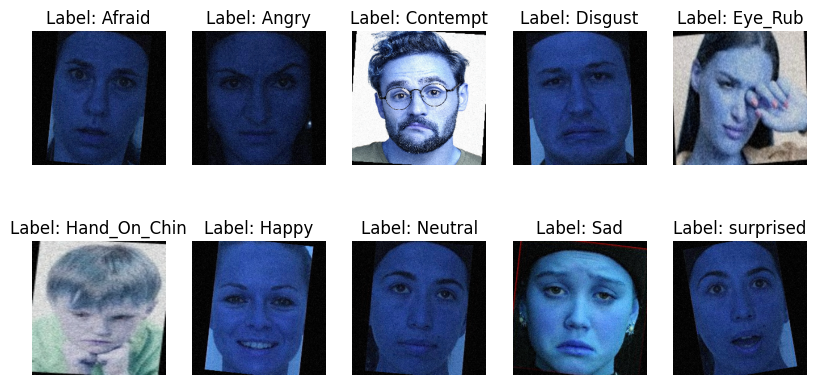

In [5]:
UNIQUE_LABELS, UNIQUE_INDICES = np.unique(LABELS, return_index=True)

UNIQUE_IMAGES = [IMAGES[i+1] for i in UNIQUE_INDICES]

ROWS, COLS = 2, 5

plt.figure(figsize=(10, 5))
for i, (img, label) in enumerate(zip(UNIQUE_IMAGES, UNIQUE_LABELS)):
    plt.subplot(ROWS, COLS, i + 1)
    plt.imshow(img, cmap='gray')  # Assuming grayscale images
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()


#### **APPLYING LABEL ENCODING**

In [6]:
print(f" LABEL BEFORE ENCODING : {UNIQUE_LABELS}")

LABEL_ENCODER = LabelEncoder()
Y_ENCODED = LABEL_ENCODER.fit_transform(LABELS)
Y_ONE_HOT = to_categorical(Y_ENCODED, num_classes=len(UNIQUE_LABELS))

print(f" LABEL AFTER ENCODING : {Y_ONE_HOT[0:5]}")

 LABEL BEFORE ENCODING : ['Afraid' 'Angry' 'Contempt' 'Disgust' 'Eye_Rub' 'Hand_On_Chin' 'Happy'
 'Neutral' 'Sad' 'surprised']
 LABEL AFTER ENCODING : [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### **SPLITING DATASET INTO TRAIN AND TEST**

In [7]:
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(IMAGES, Y_ONE_HOT, test_size=0.2, random_state=42)

#### **MODEL CONFIGURATION**

In [8]:
EPOCHS=30
LEARNING_RATE=0.0001
BATCH_SIZE=64
INPUT_SHAPE=(224, 224, 3)

#### **COVERTING DATA FROM NP ARRAY TO TENSORS FOR OPTIMIZED AND BETTER TRAINING PERFORMANCE**

In [9]:
TRAIN_DATASET = tf.data.Dataset.from_tensor_slices((X_TRAIN, Y_TRAIN)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
VAL_DATASET = tf.data.Dataset.from_tensor_slices((X_VAL, Y_VAL)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### **LOADING MODEL WITH PRETRAINED WEIGHTS**

In [10]:
BASE_MODEL = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

for layer in BASE_MODEL.layers[-5:]:
    layer.trainable=False
    
x = BASE_MODEL.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(10, activation='softmax')(x) 

MODEL = Model(inputs=BASE_MODEL.input, outputs=out)

MODEL.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### **CHECKING MODEL DETAILS EG.LAYERS,NUMBER OF TRAINABLE PARAMETER ,NON TRAINABLE ETC**

In [18]:
MODEL.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 3,887,110 (14.83 MB)

 Non-trainable params: 823,463 (3.14 MB)

#### **DEFINING FUNCTION FOR VISUALIZATION OF TRAINING ,VALIDATION LOSS & ACCURACY**

In [11]:
HISTORY = MODEL.fit(TRAIN_DATASET, validation_data=VAL_DATASET, epochs=EPOCHS)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.3193 - loss: 1.9048 - val_accuracy: 0.3360 - val_loss: 1.6463
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 237ms/step - accuracy: 0.6923 - loss: 0.7913 - val_accuracy: 0.6830 - val_loss: 0.7736
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.8612 - loss: 0.4171 - val_accuracy: 0.8500 - val_loss: 0.4123
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.9255 - loss: 0.2213 - val_accuracy: 0.8840 - val_loss: 0.3044
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.9710 - loss: 0.1141 - val_accuracy: 0.9170 - val_loss: 0.2197
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.9810 - loss: 0.0723 - val_accuracy: 0.9170 - val_loss: 0.2043
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9891 - loss: 0.0438 - val_accuracy: 0.9610 - val_loss: 0.1077
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.9913 - loss: 0.0312 - val_accura

#### EVALUATING THE MODEL ACCURACY AND LOSS

In [12]:
VAL_LOSS, VAL_ACCURACY = MODEL.evaluate(VAL_DATASET)

print(f"Validation Loss: {VAL_LOSS:.4f}")
print(f"Validation Accuracy: {VAL_ACCURACY:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9651 - loss: 0.1098
Validation Loss: 0.1082
Validation Accuracy: 0.9670


#### DEFINING FUNCTION FOR VISUALIZATION OF TRAINING ,VALIDATION LOSS & ACCURACY

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



def PLOT_TRAINING_CURVES(HISTORY):
    EPOCHS = range(1, len(HISTORY.history['accuracy']) + 1)
    plt.figure(figsize=(8, 10))
    
    # PLOT accuracy
    plt.subplot(2, 1, 1)
    plt.plot(EPOCHS, HISTORY.history['accuracy'], label='TRAINING ACCURACY', linestyle='-')
    plt.plot(EPOCHS, HISTORY.history['val_accuracy'], label='VALIDATION ACCURACY', linestyle='--')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.legend()
    plt.title('TRAINING AND VALIDATION ACCURACY')
    plt.grid(True)
    
    # PLOT loss
    plt.subplot(2, 1, 2)
    plt.plot(EPOCHS, HISTORY.history['loss'], label='Training Loss', linestyle='-')
    plt.plot(EPOCHS, HISTORY.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend()
    plt.title('TRAINING AND VALIDATION LOSS')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### VISUALLY ANALYZING THE MODEL TRAINING ACCURACY AND LOSS

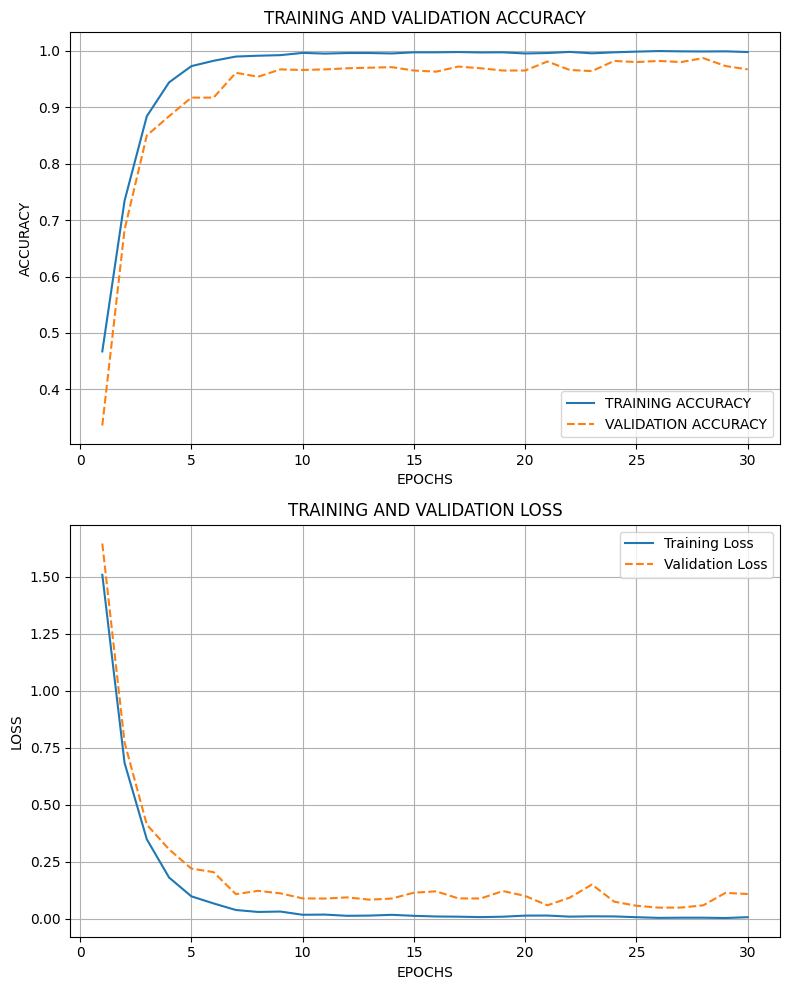

In [14]:

PLOT_TRAINING_CURVES(HISTORY)

#### FUNCTION FOR REPORT AND SCORE SUCH AS (ACCURACY,PRECISION ,RECALL,F1_SOCRE)

In [15]:
def EVALUATE_CLASSIFICATION_METRICS(MODEL, X_TEST, Y_TEST):
    
    Y_PRED = MODEL.predict(X_TEST)
    Y_PRED_CLASSES = Y_PRED.argmax(axis=1)
    Y_TRUE_CLASSES = Y_TEST.argmax(axis=1)
    
    accuracy = accuracy_score(Y_TRUE_CLASSES, Y_PRED_CLASSES)
    precision = precision_score(Y_TRUE_CLASSES, Y_PRED_CLASSES, average='weighted')
    recall = recall_score(Y_TRUE_CLASSES, Y_PRED_CLASSES, average='weighted')
    f1 = f1_score(Y_TRUE_CLASSES, Y_PRED_CLASSES, average='weighted')
    
    print(f'ACCURACY: {accuracy:.4f}')
    print(f'PRECISION: {precision:.4f}')
    print(f'RECALL: {recall:.4f}')
    print(f'F1 SCORE: {f1:.4f}')
    print('\nCLASSIFICATION REPORT:\n', classification_report(Y_TRUE_CLASSES, Y_PRED_CLASSES))

#### CALLING FUNCTION FOR GENERATING MODEL REPORT

In [16]:
EVALUATE_CLASSIFICATION_METRICS(MODEL, X_VAL, Y_VAL)

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step
ACCURACY: 0.9670
PRECISION: 0.9695
RECALL: 0.9670
F1 SCORE: 0.9668

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        98
           1       0.96      0.98      0.97       111
           2       1.00      1.00      1.00        81
           3       1.00      0.93      0.96       112
           4       1.00      1.00      1.00        98
           5       1.00      1.00      1.00        94
           6       0.94      1.00      0.97       111
           7       0.94      0.99      0.96       105
           8       0.98      0.93      0.96       105
           9       0.87      1.00      0.93        85

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



#### CONFUSION MATRIX FOR MODEL PERFORMANCE EVALUATION

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


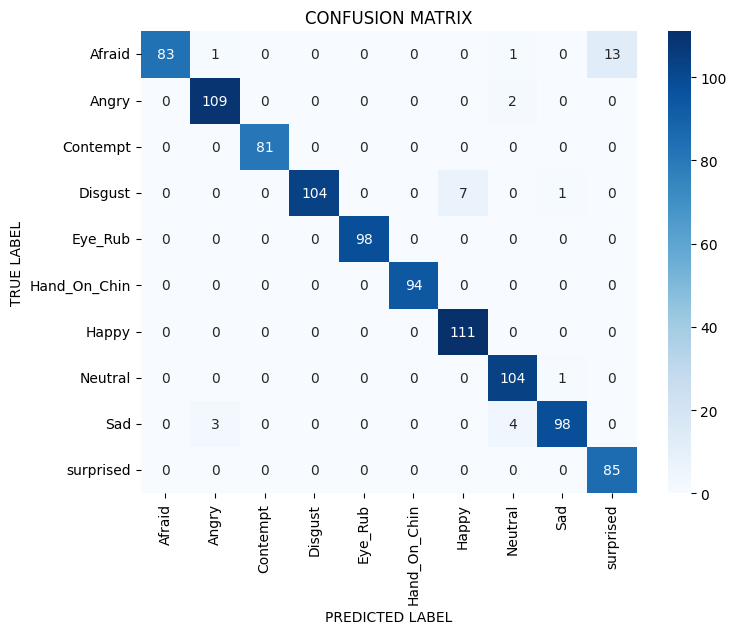

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

Y_TRUE_LIST = []
X_VAL_LIST = []

for x_batch, y_batch in VAL_DATASET:
    X_VAL_LIST.append(x_batch.numpy()) 
    Y_TRUE_LIST.append(y_batch.numpy())

X_VAL_FULL = np.concatenate(X_VAL_LIST, axis=0)
Y_TRUE = np.concatenate(Y_TRUE_LIST, axis=0)

Y_TRUE = np.argmax(Y_TRUE, axis=1)

Y_PRED_PROBS = MODEL.predict(X_VAL_FULL)

Y_PRED = np.argmax(Y_PRED_PROBS, axis=1)

CONFUSION_MATRIX = confusion_matrix(Y_TRUE, Y_PRED)

plt.figure(figsize=(8, 6))
sns.heatmap(CONFUSION_MATRIX, annot=True, fmt="d", cmap="Blues", 
            xticklabels=LABEL_ENCODER.classes_, 
            yticklabels=LABEL_ENCODER.classes_)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title("CONFUSION MATRIX")
plt.show()


In [ ]:
MODEL.save("facial_Expression_model_EfficientNetB0.h5")